In [1]:
import json
import matplotlib.pyplot as plt
import datetime
import numpy as np
import mpl_axes_aligner
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import matplotlib.ticker as ticker

In [2]:
def align_yaxis(ax1, v1, ax2, v2):
    _, y1 = ax1.transData.transform((0, v1))
    _, y2 = ax2.transData.transform((0, v2))
    inv = ax2.transData.inverted()
    _, dy = inv.transform((0, 0)) - inv.transform((0, y1-y2))
    miny, maxy = ax2.get_ylim()
    ax2.set_ylim(miny+dy, maxy+dy)

In [3]:
provinces=['Eastern Cape','Free State','Gauteng','KwaZulu-Natal','Limpopo','Mpumalanga','North West','Northern Cape','Western Cape']
headings=['Facilities Reporting','Admissions to Date','Died to Date','Discharged to Date','Currently Admitted','Currently in ICU','Currently Ventilated','Currently Oxygenated','Admissions in Previous Day']

<Figure size 432x288 with 0 Axes>

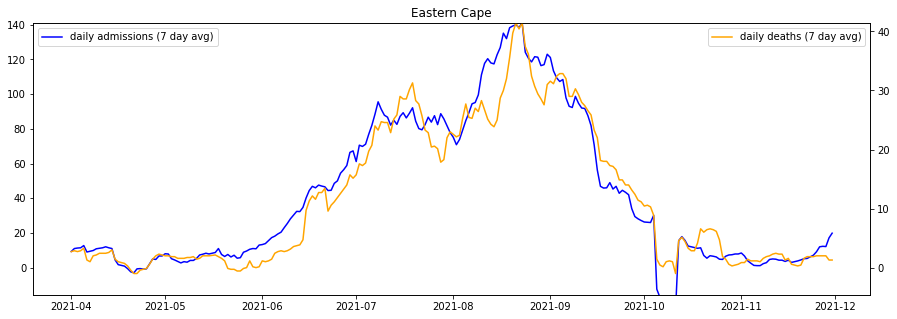

<Figure size 432x288 with 0 Axes>

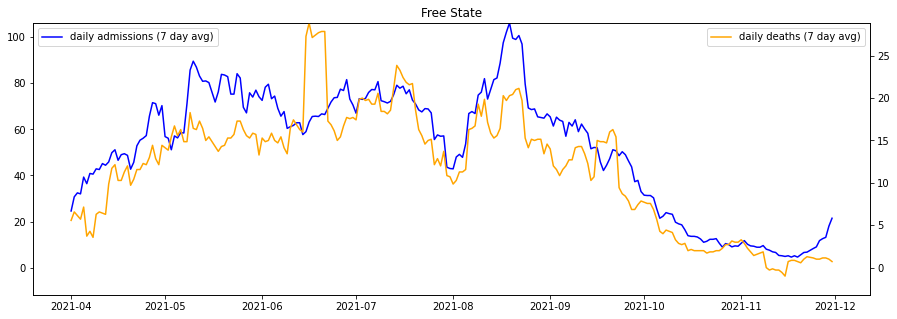

<Figure size 432x288 with 0 Axes>

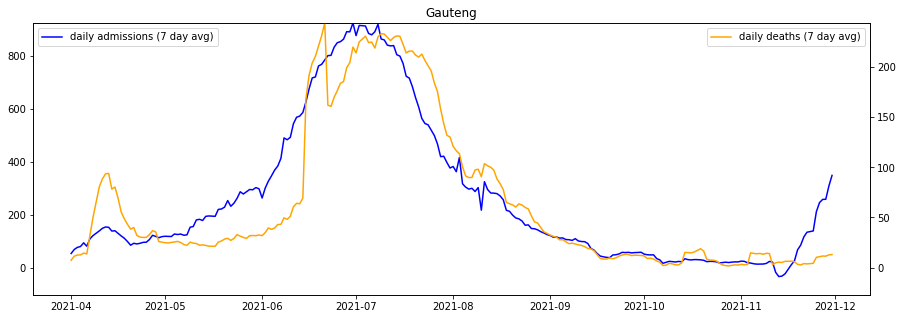

<Figure size 432x288 with 0 Axes>

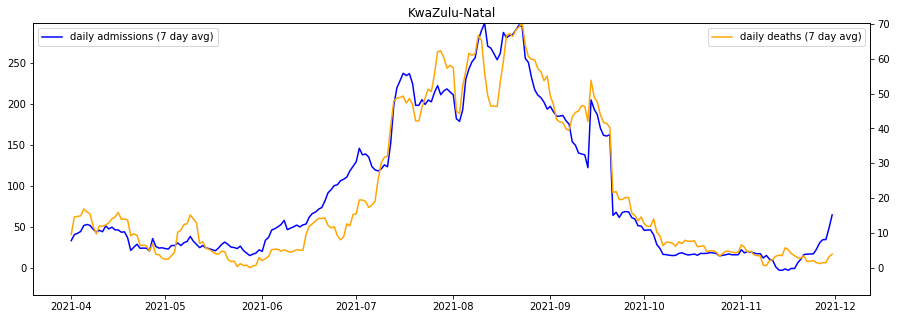

<Figure size 432x288 with 0 Axes>

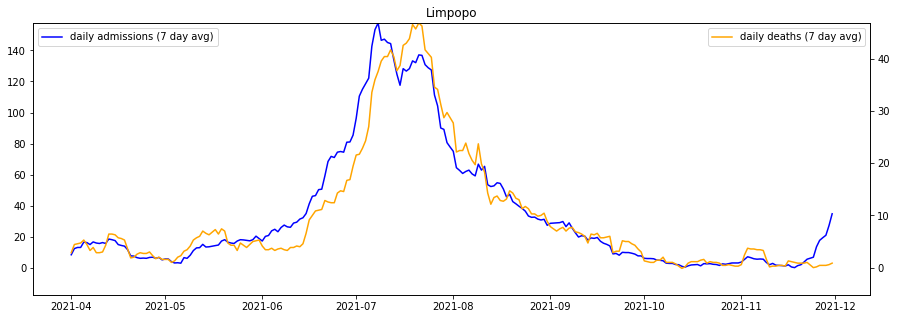

<Figure size 432x288 with 0 Axes>

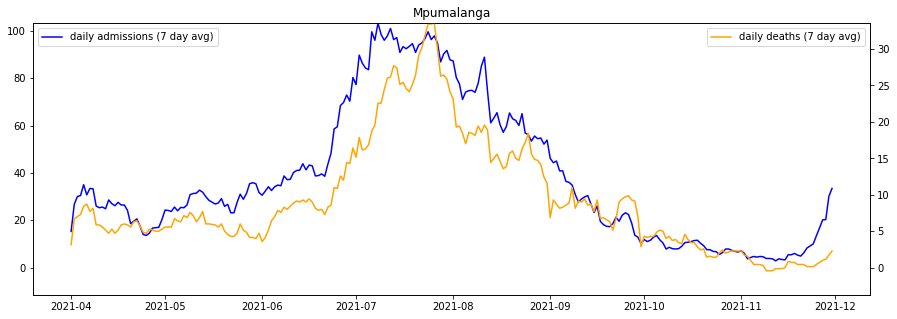

<Figure size 432x288 with 0 Axes>

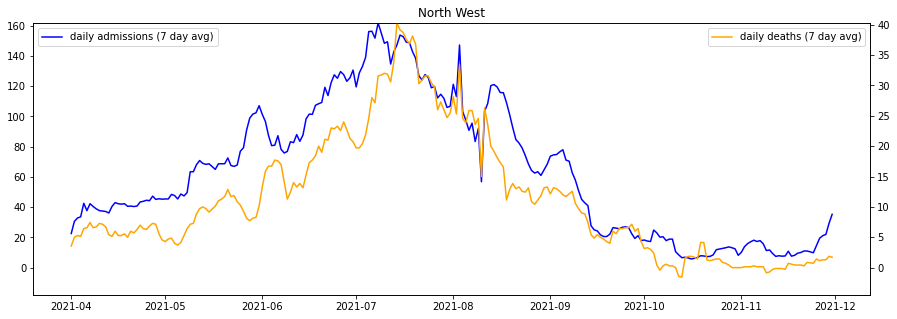

<Figure size 432x288 with 0 Axes>

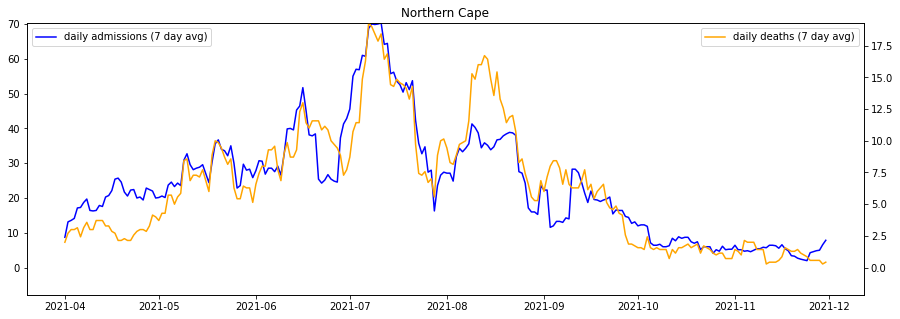

<Figure size 432x288 with 0 Axes>

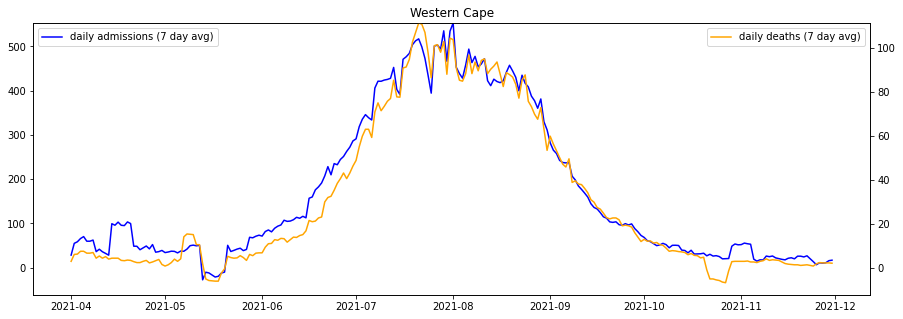

In [4]:
with open("SouthAfricaHospData.json", "r") as f:
    data = json.load(f)
    
startDate = datetime.datetime(2021, 4, 1)
endDate = datetime.datetime.now()

def N_avg(a, N=7):
    # hard edged convolution into past, preserve len(a) by nan-ing
    b = np.zeros(len(a))
    for i in range(N-1):
        b[i] = np.nan
    for i in range(N-1,len(a),1):
        b[i] = np.mean(a[i-N+1:i+1])
    return b    

xs = []
y_admiss = {}
y_died = {}

for province in provinces:
    xs = []
    _y_admiss_cum = []
    _y_died_cum = []
    for date, _d in data.items():
        if date=="2020-05-25" or date=="2020-05-24" or date=="2021-11-23":
            continue
        d = data[date][province]
        x_date = datetime.datetime.strptime(date, '%Y-%m-%d')
        if x_date > endDate or x_date < startDate:
            continue
        if not "Admissions in Previous Day" in d.keys():
            continue
        _y_admiss_cum.append(d["Admissions to Date"])
        _y_died_cum.append(d["Died to Date"])
        xs.append(x_date)
    
    _y_admiss = np.flip(np.diff(np.flip(_y_admiss_cum)))
    _y_died = np.flip(np.diff(np.flip(_y_died_cum)))
    
    y_admiss[province] = np.flip(N_avg(_y_admiss)[7:])
    y_died[province] = np.flip(N_avg(_y_died)[7:])
    xs = np.flip(xs[8:])
    
    plt.clf()
    fig, ax1 = plt.subplots(1,1, figsize=(15,5))
    ax2 = ax1.twinx()
    ax1.plot(xs, y_admiss[province], label="daily admissions (7 day avg)", color="blue")
    ax2.plot(xs, y_died[province], label="daily deaths (7 day avg)", color="orange")
    plt.title(province)
    ax1.set_ylim(0, np.max(y_admiss[province]))
    ax2.set_ylim(0, np.max(y_died[province]))
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
    #plt.savefig(province+"_raw.png", bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()

In [16]:
def cumsumflip(x):
    return np.flip(np.cumsum(np.flip(x)))

def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    _x = cumsumflip(x)
    pred_out_stream = np.convolve(in_stream, _x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs):
    province = "Limpopo" # chosen for data not looking all that broken
    in_stream = y_admiss[province]  
    out_stream = y_died[province]
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.linalg.norm(pred_out_stream - target_out_stream, ord=2) / len(pred_out_stream)
        ret[i] += 1e4*abs(1-np.sum(x)) if np.sum(x)>1 else 0
    return ret    

In [18]:
n_dim = 20
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = -0.02*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
bounds = (x_min, x_max)
#init_pos = np.array([0*x_min for i in range(n_particles)])
init_pos = None

outputs = []

for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    outputs.append(pos)
outputs = np.array(outputs)

2021-12-10 00:30:34,491 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.217
2021-12-10 00:30:43,124 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.2165186137478981, best pos: [-0.01145941  0.00670298  0.00341906  0.00829792 -0.01310152  0.01811546
  0.0332856   0.00135661 -0.00484237  0.04148916  0.01036542 -0.01544192
 -0.01288496 -0.01618002 -0.00363071 -0.00826906 -0.00886444  0.02189958
 -0.00584121  0.0048546 ]
2021-12-10 00:30:43,131 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.161
2021-12-10 00:30:51,424 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.16147784393956846, best pos: [ 0.0254438   0.02581448  0.00095206  0.03287868  0.00068915 -0.00382865
  0.01118105 -0.00183982  0.0

pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.195
2021-12-10 00:32:40,436 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.19451016797775025, best pos: [ 0.04616126  0.00817909  0.02858535  0.00865534  0.01688429  0.00232119
  0.02078917 -0.00130562 -0.00734668 -0.00662137 -0.01142905  0.00704252
  0.01361885 -0.00458201 -0.0052088  -0.01563657  0.00123835  0.00191619
 -0.0050582   0.01505896]
2021-12-10 00:32:40,446 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.6, 'c2': 0.3, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=0.198
2021-12-10 00:32:48,712 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 0.19834283187377666, best pos: [ 0.05219211  0.04820574  0.03007735  0.03584135  0.01262475 -0.00321683
 -0.00607864 -0.00121443 -0.01335571  0.01094283 -0.00951109 -0.0168448
 -0.00693862 -0.00905839 -0.00244068  0.03048223 -0.01841549  0.01467485
  0.01274

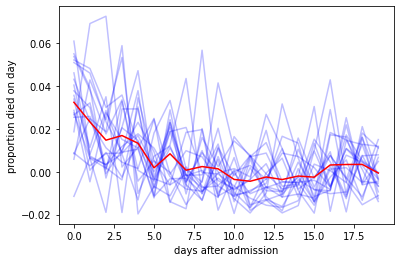

0.10663707600987499


In [19]:
plt.clf()
x = list(range(len(pos)))
for v in outputs:
    plt.plot(x, v, color="blue", alpha=0.25)
v_avg = []
for i in range(len(v)):
    v_avg.append(np.mean(outputs[:,i]))
plt.plot(x, v_avg, color="red", alpha=1)
plt.xlabel("days after admission")
plt.ylabel("proportion died on day")
plt.savefig("convolution.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print(np.sum(v_avg))

<Figure size 432x288 with 0 Axes>

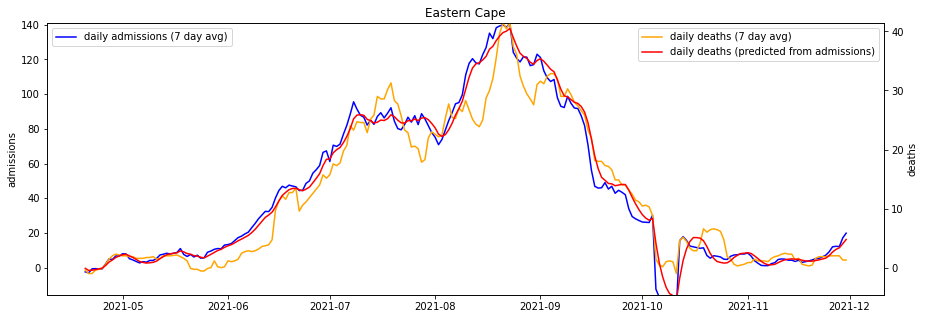

<Figure size 432x288 with 0 Axes>

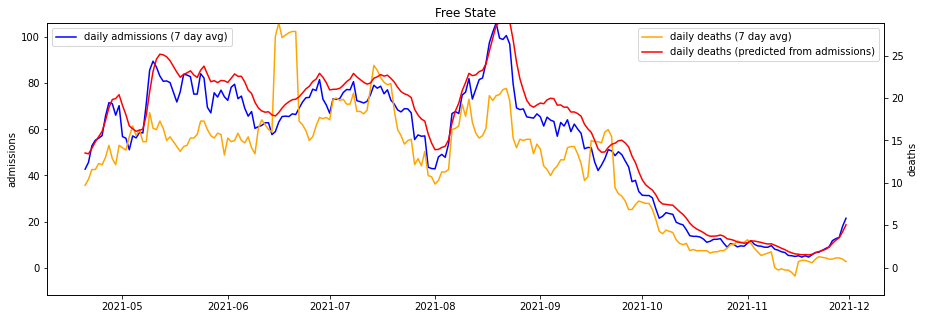

<Figure size 432x288 with 0 Axes>

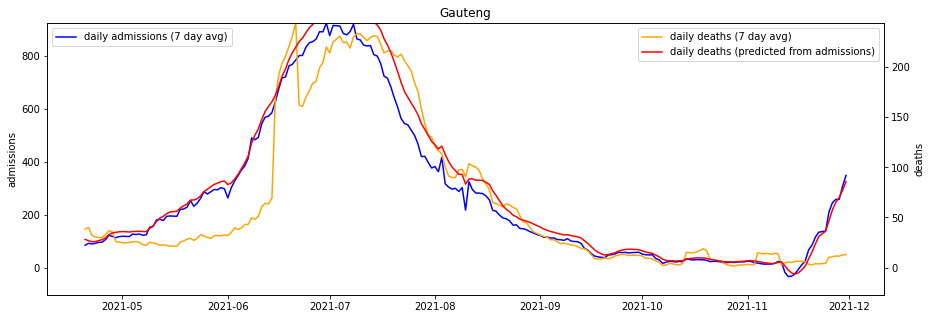

<Figure size 432x288 with 0 Axes>

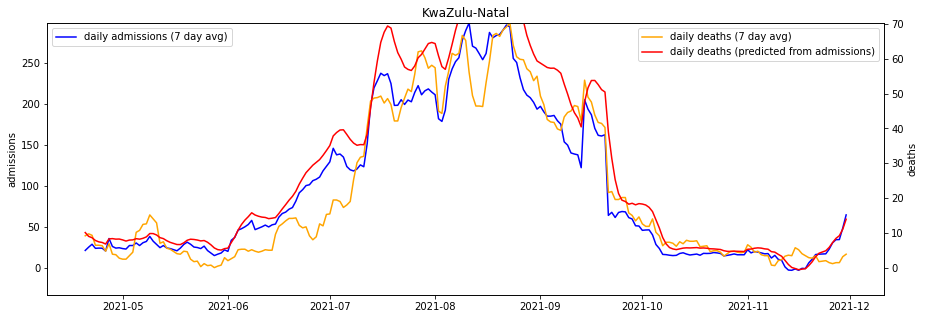

<Figure size 432x288 with 0 Axes>

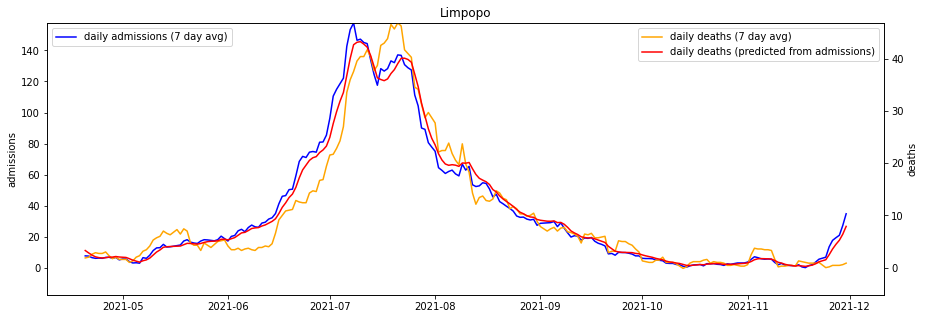

<Figure size 432x288 with 0 Axes>

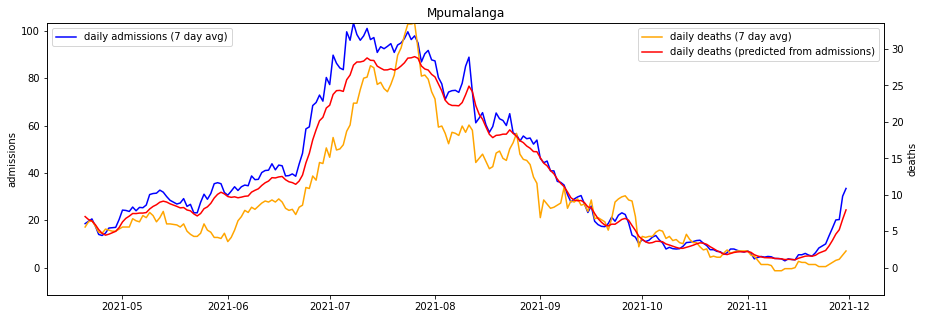

<Figure size 432x288 with 0 Axes>

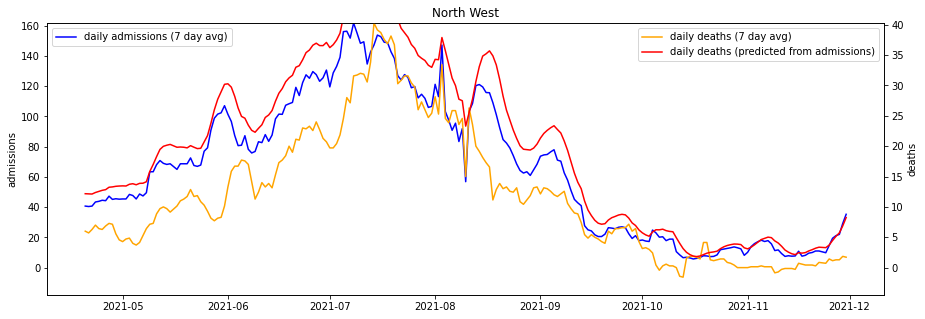

<Figure size 432x288 with 0 Axes>

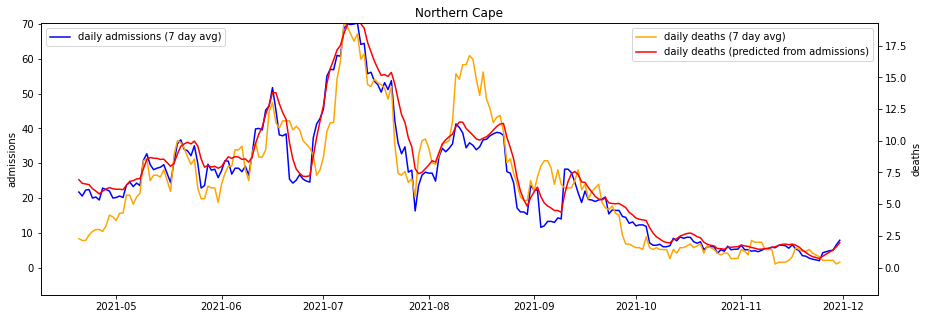

<Figure size 432x288 with 0 Axes>

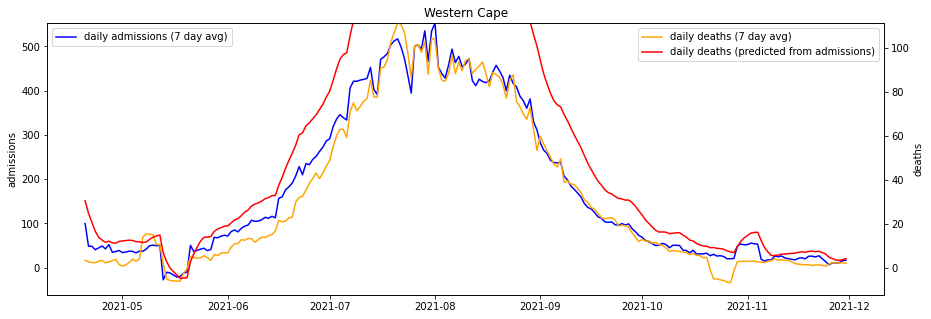

In [20]:
for province in provinces:
    plt.clf()
    true, pred = _g(v_avg, y_admiss[province], y_died[province]) 
    x = xs[-len(true):]

    plt.clf()
    fig, ax1 = plt.subplots(1,1, figsize=(15,5))
    ax2 = ax1.twinx()    
    ax1.plot(x, y_admiss[province][-len(true):], label="daily admissions (7 day avg)", color="blue")
    ax2.plot(x, y_died[province][-len(true):], label="daily deaths (7 day avg)", color="orange")
    ax2.plot(x, pred, label="daily deaths (predicted from admissions)", color="red")
    plt.title(province)
    ax1.legend(loc="upper left")
    ax2.legend(loc="upper right")
    ax1.set_ylim(0,np.max(y_admiss[province]))
    ax2.set_ylim(0,np.max(y_died[province]))
    ax1.set_ylabel("admissions")
    ax2.set_ylabel("deaths")
    mpl_axes_aligner.align.yaxes(ax1, 0, ax2, 0, 0.1)
    plt.savefig(province+"_pred.png", bbox_inches='tight', facecolor='white', transparent=False)
    plt.show()    
    